# Using Clustering Methodologies to Improve Zestimate Results

###### Chad Allen
###### 28 June 2021

## Project Description

Zillow: What is driving the errors in the Zestimates?

For this project, work will continue with the Zillow dataset using the 2017 properties and predictions data for single unit / single family homes.

This notebook consists of continued work from the regression project, incorporating clustering methodologies to help uncover drivers of the error in Zestimates.

## Goals

- Identify the drivers(features) for errors in Zestimates by incorporating clustering methodologies.
- Document the process and analysis through the data science pipeline.
- Construct a model for predicting errors in Zestimates that will do better than a baseline model.

## Deliverables

- Jupyter Notebook report detailing the process through the pipeline.
- Acquire and Prepare modules used in the notebook and for recreating the process.
- README file that details the project, documents the project planning, and instructions on how to recreate.

## Key Findings

- focused on property features with high correlations
- cluster with highest relation to logerror proved to be not very useful
- Polynomial Regression model with cluster showed sliver of improvement over baseline
- more time and iterations could yield better results

## Project Planning

- Acquire data from Zillow database
- Prepare and clean the data
- Explore the data
-- use visualizations and statistical testing to explore the relationships between varaibles and the target
-- create clusters and use visualizations and statistical testing to determine if they are useful
- Model and Evaluate the data
-- establish the baseline
-- use features and cluster in regression models
- Use best model on test data
- Conclusions

## Imports

In [1]:
# standard imports
import math
import pandas as pd
import numpy as np

# analysis imports
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

# visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# compiled modules
import acquire
import prepare

# block warnings
import warnings
warnings.filterwarnings("ignore")

## Acquire

In [2]:
# use imported function to acquire the data, then take a quick look at columns and values
df = acquire.get_zillow_data()
df.head()

,parcelid,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,id,basementsqft,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,14297519,NaN,NaN,261.0,NaN,NaN,NaN,NaN,1727539,NaN,...,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,17052889,NaN,NaN,261.0,NaN,NaN,NaN,NaN,1387261,NaN,...,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,14186244,NaN,NaN,261.0,NaN,NaN,NaN,NaN,11677,NaN,...,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,12177905,NaN,NaN,261.0,2.0,NaN,NaN,NaN,2288172,NaN,...,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,10887214,NaN,NaN,266.0,2.0,NaN,NaN,1.0,1970746,NaN,...,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


In [3]:
df.shape

(77574, 68)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77574 entries, 0 to 77573
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77574 non-null  int64  
 1   typeconstructiontypeid        222 non-null    float64
 2   storytypeid                   50 non-null     float64
 3   propertylandusetypeid         77574 non-null  float64
 4   heatingorsystemtypeid         49569 non-null  float64
 5   buildingclasstypeid           15 non-null     float64
 6   architecturalstyletypeid      206 non-null    float64
 7   airconditioningtypeid         25006 non-null  float64
 8   id                            77574 non-null  int64  
 9   basementsqft                  50 non-null     float64
 10  bathroomcnt                   77574 non-null  float64
 11  bedroomcnt                    77574 non-null  float64
 12  buildingqualitytypeid         49808 non-null  float64
 13  c

 Takeaways:
- lots of missing values
- lots of redundant and unneeded columns
- object columns that can't be used for analysis

## Prepare

In [5]:
# check for missing and dulicate values
prepare.miss_dup_values(df)

Your selected dataframe has 68 columns.
There are 52 columns that have missing values.
  
** There are 0 duplicate rows that represents 0.0% of total Values**


,Missing Values,% of Total Values
buildingclasstypeid,77559,100.0
buildingclassdesc,77559,100.0
finishedsquarefeet13,77532,99.9
storydesc,77524,99.9
basementsqft,77524,99.9
storytypeid,77524,99.9
yardbuildingsqft26,77504,99.9
fireplaceflag,77402,99.8
architecturalstyletypeid,77368,99.7
architecturalstyledesc,77368,99.7


In [6]:
# use imported function to prepare the data, then look at a sample
df = prepare.prepare_zillow(df)
df.head().T

parcelid,14297519,17052889,14186244,12177905,12095076
bathrooms,3.500000e+00,1.000000e+00,2.000000e+00,3.000000e+00,3.000000e+00
bedrooms,4.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00
square_feet,3.100000e+03,1.465000e+03,1.243000e+03,2.376000e+03,2.962000e+03
county_code,6.059000e+03,6.111000e+03,6.059000e+03,6.037000e+03,6.037000e+03
latitude,3.363493e+07,3.444927e+07,3.388617e+07,3.424518e+07,3.414520e+07
longitude,-1.178692e+08,-1.192815e+08,-1.178232e+08,-1.182407e+08,-1.181798e+08
building_value,4.857130e+05,8.800000e+04,8.528900e+04,1.089180e+05,2.766840e+05
appraised_value,1.023282e+06,4.640000e+05,5.647780e+05,1.451430e+05,7.733030e+05
land_value,5.375690e+05,3.760000e+05,4.794890e+05,3.622500e+04,4.966190e+05
taxes,1.101372e+04,5.672480e+03,6.488300e+03,1.777510e+03,9.516260e+03


In [7]:
# use imported function to get detailed information
prepare.summarize(df)

DataFrame head: 
          bathrooms  bedrooms  square_feet  county_code    latitude  \
parcelid                                                              
14297519        3.5       4.0       3100.0       6059.0  33634931.0   
17052889        1.0       2.0       1465.0       6111.0  34449266.0   
14186244        2.0       3.0       1243.0       6059.0  33886168.0   

            longitude  building_value  appraised_value  land_value     taxes  \
parcelid                                                                       
14297519 -117869207.0        485713.0        1023282.0    537569.0  11013.72   
17052889 -119281531.0         88000.0         464000.0    376000.0   5672.48   
14186244 -117823170.0         85289.0         564778.0    479489.0   6488.30   

          logerror   age   taxrate     acres  bath_bed_ratio  
parcelid                                                      
14297519  0.025595  19.0  1.076313  0.103444        0.875000  
17052889  0.055619  50.0  1.222517  0

In [8]:
# check of rows and columns after cleaning
df.shape

(51663, 15)

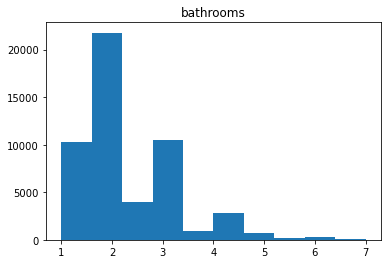

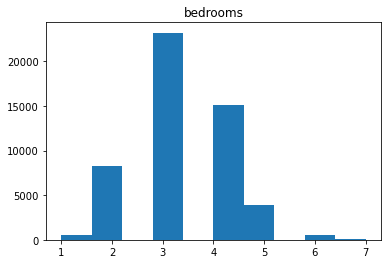

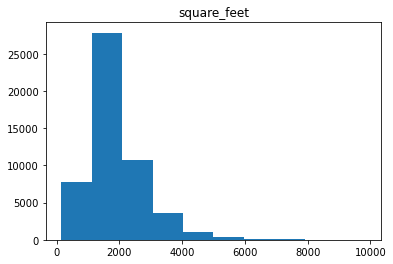

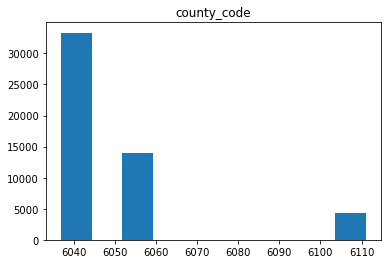

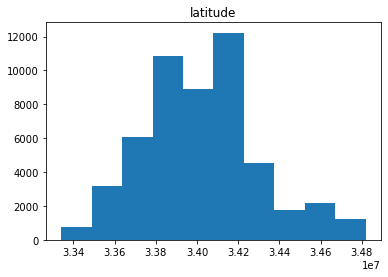

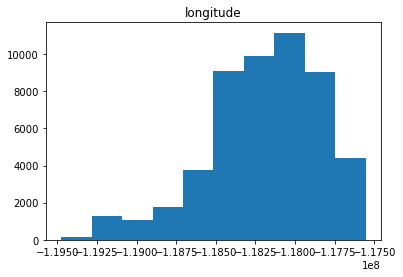

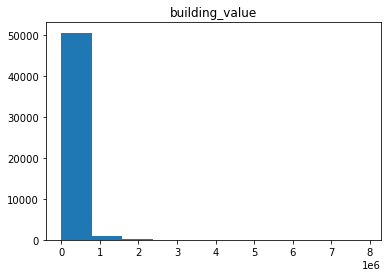

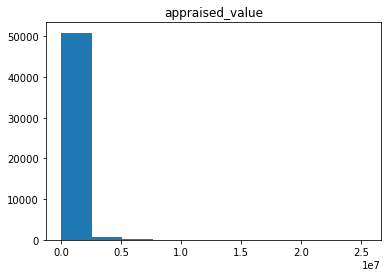

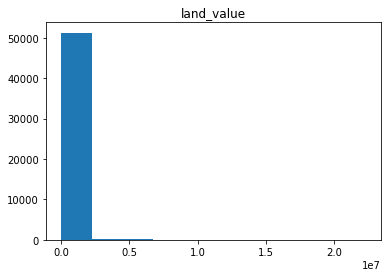

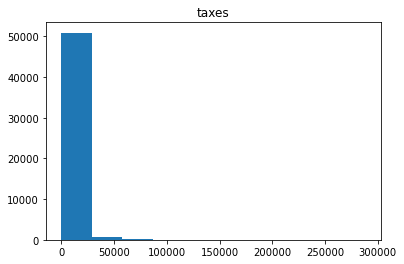

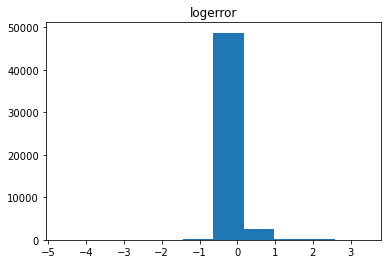

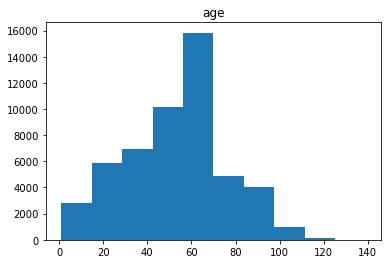

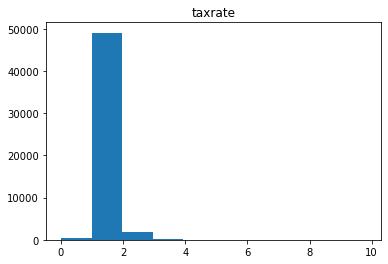

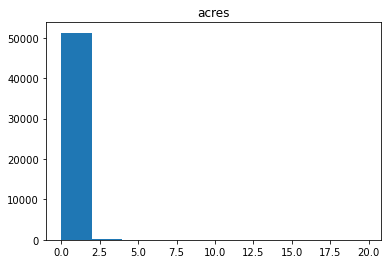

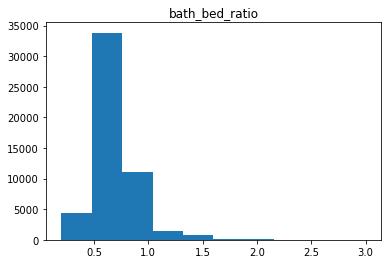

In [9]:
# plot distributions
for col in df.columns:
    plt.hist(df[col])
    plt.title(col)
    plt.show()

Takeaways:
   - bathroom distribution is right-tailed
   - bedroom distribution is mostly normal
   - square_feet distribution is centered around 1500-2000 and right-tailed
   - building_value, appraised_value, land_value, taxes, taxrate, and acres are mostly concentrated in lowest value
   - logerror is normally distributed

In [10]:
# split the data before exploration and analysis
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.split_zillow(df, 'logerror')
train.shape, X_train.shape

((28931, 15), (28931, 14))

## Explore

In [11]:
# use RFE to find best features for analysis
X = train.drop(columns='logerror')
y = train['logerror']

lm = LinearRegression()
rfe = RFE(estimator=lm, n_features_to_select=1)
rfe.fit(X, y)

# show the ranking of features
pd.Series(dict(zip(X.columns, rfe.ranking_))).sort_values()

taxrate             1
bath_bed_ratio      2
bathrooms           3
acres               4
bedrooms            5
age                 6
county_code         7
square_feet         8
taxes               9
appraised_value    10
latitude           11
building_value     12
land_value         13
longitude          14
dtype: int64

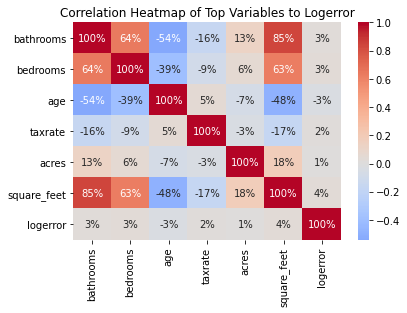

In [12]:
# examine top 6 property features (exclude bath_bed_ratio)
top_vars = train[['bathrooms', 'bedrooms', 'age',  'taxrate', 'acres', 'square_feet', 'logerror']]
sns.heatmap(top_vars.corr(), cmap='coolwarm', center=0, annot=True, fmt='.0%')
plt.title('Correlation Heatmap of Top Variables to Logerror')
plt.show()

Takeaways:
   - no strong correlations between property features and target
   - square_feet shows highest correlation, could be useful in cluster
   - bathrooms and bedrooms next highest correlations, using the ratio with other features might prove useful
   - age shows negative correlation

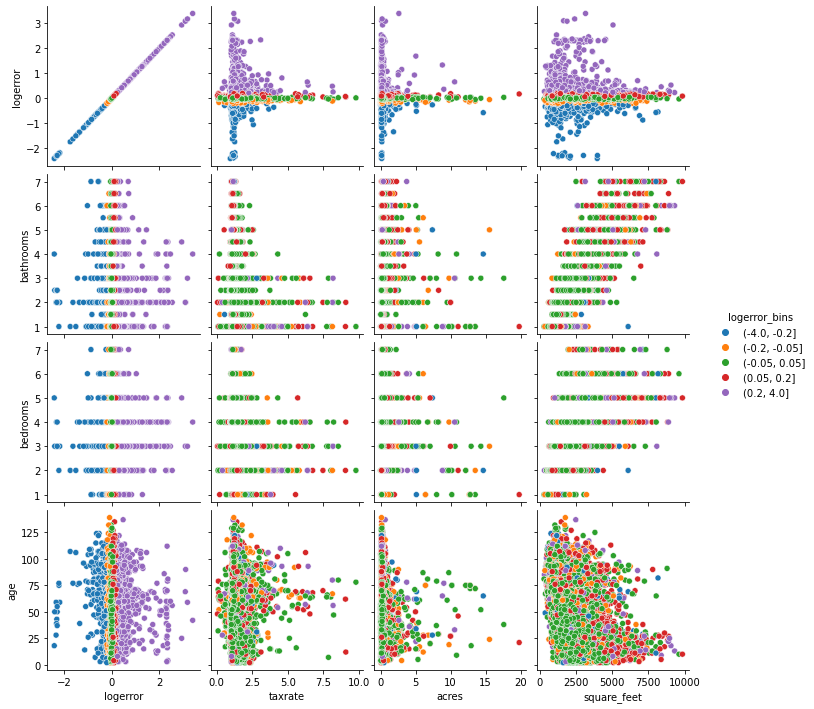

In [13]:
# quick look at the interaction of the top variables to logerror
train['logerror_bins'] = pd.cut(train.logerror, [-4, -.2, -.05, .05, .2, 4])

sns.pairplot(data = train, hue = 'logerror_bins', diag_kind=None,
             x_vars = ['logerror', 'taxrate','acres', 'square_feet'],
             y_vars = ['logerror', 'bathrooms', 'bedrooms', 'age'])
plt.show()

#### Takeaways
   - logerror appears highest in age between 30 and 60 years
   - bedrooms highest logerror rates seem to be between 2 to 5 bedrooms
   - highest logerror rates in bathrooms seems to be mostly between 1 to 3 bathroom
   - logerror appears to be normally distributed
   - logerror is highest for properties taxed under 2% taxrate
   - small acreage lots have the highest logerrors
   - majority and largest logerrors occur in smaller homes

### Univariate Exploration
- Question: Does logerror vary across bathrooms?

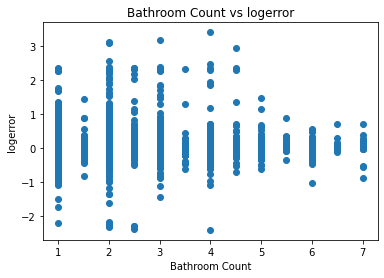

In [14]:
# look at the distributions
plt.scatter(train.bathrooms, train.logerror)
plt.xlabel('Bathroom Count')
plt.ylabel('logerror')
plt.title('Bathroom Count vs logerror')
plt.show()

In [15]:
# bin bathrooms into 2 groups
train['bathroom_bin'] = pd.cut(train.bathrooms,[1,3,7])

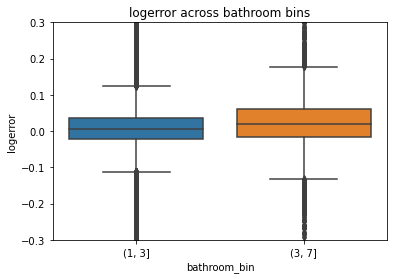

In [16]:
# examine boxplot
sns.boxplot(train.bathroom_bin, train.logerror)
plt.title('logerror across bathroom bins')
plt.ylim(-0.3, 0.3)
plt.show()

In [17]:
# test for equal variance across logerror between 3 and under bathrooms group and over 3 bathrooms group
null_hypothesis = 'the variance across logerror between groups is equal.'
alt_hypothesis = 'the variance across logerror between groups is not equal.'

alpha = 0.05

stat, p = stats.levene(train[train.bathrooms <= 3].logerror, train[train.bathrooms > 3].logerror)
stat, p

(22.497708500240993, 2.113970527388903e-06)

In [18]:
if p < alpha:
    print('Reject the null hypothesis.')
    print('There is evidence to support that', alt_hypothesis)
else:
    print('Fail to reject the null hypothesis.')
    print('There is evidence to support that', null_hypothesis)

Reject the null hypothesis.
There is evidence to support that the variance across logerror between groups is not equal.


In [19]:
# test for significant difference in logerror between 3 and under bathrooms group and over 3 bathrooms group
null_hypothesis = 'the logerror for properties with 3 or less bathrooms is the same as the logerror for properties with more than 3 bathrooms.'
alt_hypothesis = 'the logerror for properties with 3 or less bathrooms is NOT the same as the logerror for properties with more than 3 bathrooms.'

alpha = 0.05

t, p = stats.ttest_ind(train[train.bathrooms <= 3].logerror, train[train.bathrooms > 3].logerror, equal_var=False)
t, p

(-4.426563527370718, 9.880920933271076e-06)

In [20]:
if p < alpha:
    print('Reject the null hypothesis.')
    print('There is evidence to support that', alt_hypothesis)
else:
    print('Fail to reject the null hypothesis.')
    print('There is evidence to support that', null_hypothesis)

Reject the null hypothesis.
There is evidence to support that the logerror for properties with 3 or less bathrooms is NOT the same as the logerror for properties with more than 3 bathrooms.


#### Takeaways:
   - Leven test shows that variance is not equal between bathroom groups
   - T-test p-value less than alpha, thus reject the null hypothesis
   - number of bathrooms should be a good feature for modeling

### Univariate Exploration
- Question: Is there a relationship between logerror and bedrooms?

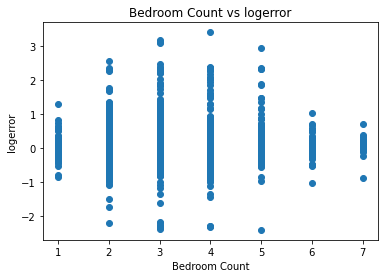

In [21]:
# look at the distributions
plt.scatter(train.bedrooms, train.logerror)
plt.xlabel('Bedroom Count')
plt.ylabel('logerror')
plt.title('Bedroom Count vs logerror')
plt.show()

In [22]:
# bin bedrooms into 2 groups
train['bedroom_bin'] = pd.cut(train.bedrooms,[1,3,7])

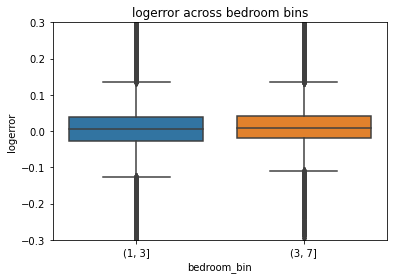

In [23]:
# examine boxplot
sns.boxplot(train.bedroom_bin, train.logerror)
plt.title('logerror across bedroom bins')
plt.ylim(-0.3, 0.3)
plt.show()

In [24]:
# test for equal variance across logerror between 3 and under bedrooms group and over 3 bedrooms group
null_hypothesis = 'the variance across logerror between groups is equal.'
alt_hypothesis = 'the variance across logerror between groups is not equal.'

alpha = 0.05

stat, p = stats.levene(train[train.bedrooms <= 3].logerror, train[train.bedrooms > 3].logerror)
stat, p

(7.460492633047636, 0.006310597112007862)

In [25]:
if p < alpha:
    print('Reject the null hypothesis.')
    print('There is evidence to support that', alt_hypothesis)
else:
    print('Fail to reject the null hypothesis.')
    print('There is evidence to support that', null_hypothesis)

Reject the null hypothesis.
There is evidence to support that the variance across logerror between groups is not equal.


In [26]:
# test for significant difference in means between 3 and under bedrooms group and over 3 bedrooms group
null_hypothesis = 'the logerror for properties with 3 or less bedrooms is the same as the logerror for properties with more than 3 bedrooms.'
alt_hypothesis = 'the logerror for properties with 3 or less bedrooms is NOT the same as the logerror for properties with more than 3 bedrooms.'

alpha = 0.05

t, p = stats.ttest_ind(train[train.bedrooms <= 3].logerror, train[train.bedrooms > 3].logerror, equal_var=False)
t, p

(-5.161194407220748, 2.4748363160893255e-07)

In [27]:
if p < alpha:
    print('Reject the null hypothesis.')
    print('There is evidence to support that', alt_hypothesis)
else:
    print('Fail to reject the null hypothesis.')
    print('There is evidence to support that', null_hypothesis)

Reject the null hypothesis.
There is evidence to support that the logerror for properties with 3 or less bedrooms is NOT the same as the logerror for properties with more than 3 bedrooms.


#### Takeaways:
   - Leven test shows variance between groups is equal
   - T-test p-value lower than alpha, thus reject the null hypothesis
   - number of bedrooms should be a good feature for modeling

### Multivariate Exploration
- Question: If we control for acres, does logerror differ across taxes?

In [28]:
# find the mean of 'acres', decided to round acres to 0.25 (1/4 acre lot) for this comparison
train.acres.mean()

0.22757313330197057

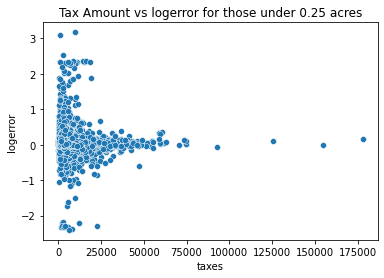

In [29]:
# examine the plot of logerror to taxes for lots equal to or under 0.25 acres
sns.scatterplot(x='taxes', y='logerror', data=train[train.acres <= 0.25])
plt.title('Tax Amount vs logerror for those under 0.25 acres')
plt.show()

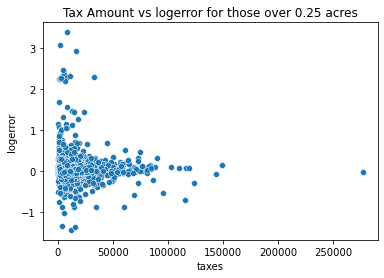

In [30]:
# examine the plot of logerror to taxes for lots over 0.25 acres
sns.scatterplot(x='taxes', y='logerror', data=train[train.acres > 0.25])
plt.title('Tax Amount vs logerror for those over 0.25 acres')
plt.show()

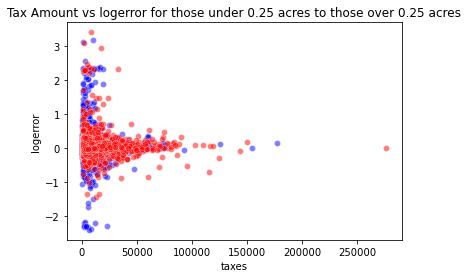

In [31]:
# plot of logerror to taxes for both groups
sns.scatterplot(x='taxes', y='logerror', data=train[train.acres <= 0.25], color='blue', alpha=0.5)
sns.scatterplot(x='taxes', y='logerror', data=train[train.acres > 0.25], color='red', alpha=0.5)
plt.title('Tax Amount vs logerror for those under 0.25 acres to those over 0.25 acres')
plt.show()

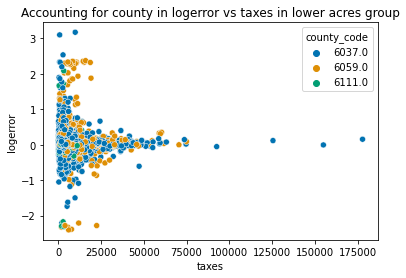

In [32]:
# examine logerror to taxes by county
sns.scatterplot(x='taxes', y='logerror', data=train[train.acres <= 0.25], hue='county_code', palette='colorblind')
plt.title('Accounting for county in logerror vs taxes in lower acres group')
plt.show()

#### Takeaways:
- the majority and larger errors seem to occur mostly in properties with lower taxes
- majority of occurances are in LA(6037) County, along with highest tax amounts
- more of the larger errors are in Orange(6059) County

### Cluster #1
- combine 'square_feet' and 'acres' into 'overall_size' cluster

In [33]:
# make 'overall_size' cluster and add to subsets
X1_train = train[['square_feet', 'acres']]
X1_validate = validate[['square_feet', 'acres']]
X1_test = test[['square_feet', 'acres']]
X1_train.head()

,square_feet,acres
parcelid,,
11097148,1479.0,0.180005
13904783,1432.0,0.156841
11558242,2844.0,0.133287
11884010,3537.0,0.294605
17258285,496.0,0.137695


In [34]:
# scale the X's for analysis
scaler = MinMaxScaler().fit(X1_train)
X1_train_scaled = pd.DataFrame(scaler.transform(X1_train), columns= X1_train.columns).set_index([X1_train.index.values])
X1_validate_scaled = pd.DataFrame(scaler.transform(X1_validate), columns= X1_validate.columns).set_index([X1_validate.index.values])
X1_test_scaled = pd.DataFrame(scaler.transform(X1_test), columns= X1_test.columns).set_index([X1_test.index.values])
X1_train_scaled.head()

,square_feet,acres
11097148,0.123481,0.008472
13904783,0.118559,0.007301
11558242,0.266443,0.006111
11884010,0.339024,0.014265
17258285,0.020528,0.006333


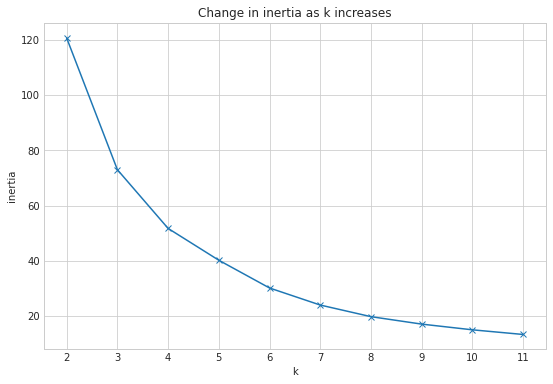

In [35]:
# plot inertia vs k for 'overall_size' cluster
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X1_train_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [36]:
# chose to examine 3 clusters, then make, fit and use the model to make centroids and predictions
kmeans = KMeans(n_clusters=3, random_state = 1234)

kmeans.fit(X1_train_scaled)

centroids1 = pd.DataFrame(kmeans.cluster_centers_, columns = X1_train_scaled.columns)

X1_train_scaled['cluster'] = kmeans.predict(X1_train_scaled)
train['size_clusters'] = X1_train_scaled['cluster']

X1_train_scaled.head()

,square_feet,acres,cluster
11097148,0.123481,0.008472,1
13904783,0.118559,0.007301,1
11558242,0.266443,0.006111,0
11884010,0.339024,0.014265,2
17258285,0.020528,0.006333,1


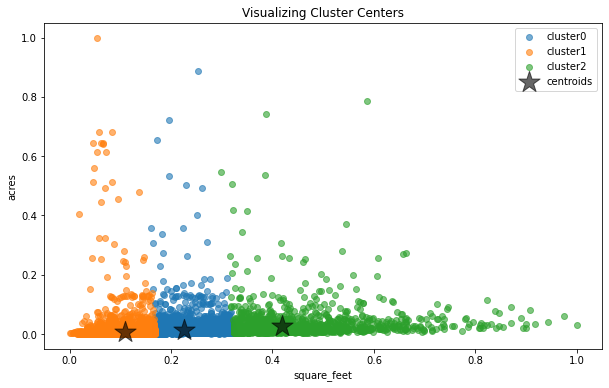

In [37]:
# visualize the clusters along with the centroids
plt.figure(figsize=(10, 6))

for cluster, subset in X1_train_scaled.groupby('cluster'):
    plt.scatter(subset.square_feet, subset.acres, label='cluster' + str(cluster), alpha=.6)

centroids1.plot.scatter(x='square_feet', y='acres', ax=plt.gca(), s=500, color='k', alpha=0.6, marker='*', label='centroids')

plt.title('Visualizing Cluster Centers')
plt.legend()
plt.show()

#### Takeaways
- most properties have low acreage
- most properties have average or less square footage

### Cluster #2
- combine 'bath_bed_ratio' and 'appraised_value' into 'bbratio_value' cluster

In [38]:
# make 'bbratio_value' cluster and add to subsets
X2_train = train[['bath_bed_ratio', 'appraised_value']]
X2_validate = validate[['bath_bed_ratio', 'appraised_value']]
X2_test = test[['bath_bed_ratio', 'appraised_value']]
X2_train.head()

,bath_bed_ratio,appraised_value
parcelid,,
11097148,0.500000,129739.0
13904783,0.666667,521000.0
11558242,1.250000,1820000.0
11884010,0.750000,1171478.0
17258285,1.000000,199654.0


In [39]:
# scale the X's for analysis
scaler = MinMaxScaler().fit(X2_train)
X2_train_scaled = pd.DataFrame(scaler.transform(X2_train), columns= X2_train.columns).set_index([X2_train.index.values])
X2_validate_scaled = pd.DataFrame(scaler.transform(X2_validate), columns= X2_validate.columns).set_index([X2_validate.index.values])
X2_test_scaled = pd.DataFrame(scaler.transform(X2_test), columns= X2_test.columns).set_index([X2_test.index.values])
X2_train_scaled.head()

,bath_bed_ratio,appraised_value
11097148,0.107143,0.005302
13904783,0.166667,0.021704
11558242,0.375000,0.076157
11884010,0.196429,0.048972
17258285,0.285714,0.008233


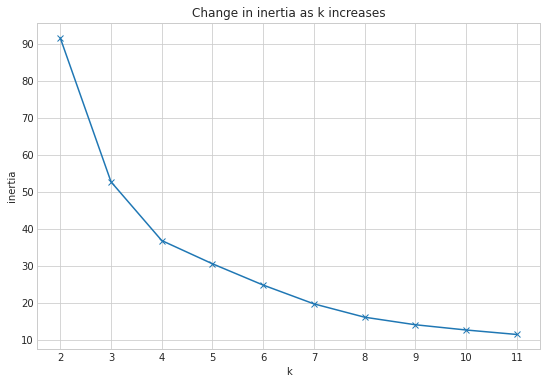

In [40]:
# plot inertia vs k for 'bbratio_value' cluster
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X2_train_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [41]:
# chose to examine 3 clusters, then make, fit and use the model to make centroids and predictions
kmeans = KMeans(n_clusters=3, random_state = 1234)

kmeans.fit(X2_train_scaled)

centroids2 = pd.DataFrame(kmeans.cluster_centers_, columns = X2_train_scaled.columns)

X2_train_scaled['cluster'] = kmeans.predict(X2_train_scaled)
train['bbratio_value_cluster'] = X2_train_scaled['cluster']

X2_train_scaled.head()

,bath_bed_ratio,appraised_value,cluster
11097148,0.107143,0.005302,2
13904783,0.166667,0.021704,0
11558242,0.375000,0.076157,1
11884010,0.196429,0.048972,0
17258285,0.285714,0.008233,1


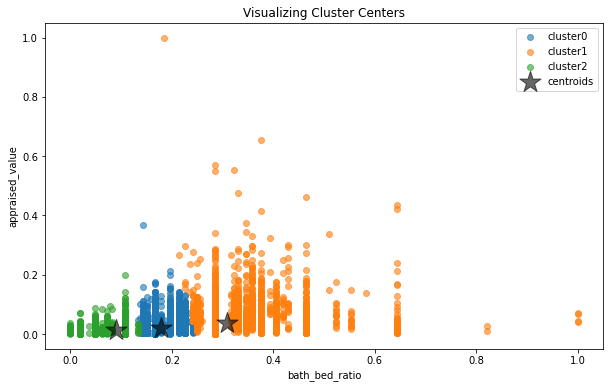

In [42]:
# visualize the clusters along with the centroids
plt.figure(figsize=(10, 6))

for cluster, subset in X2_train_scaled.groupby('cluster'):
    plt.scatter(subset.bath_bed_ratio, subset.appraised_value, label='cluster' + str(cluster), alpha=.6)

centroids2.plot.scatter(x='bath_bed_ratio', y='appraised_value', ax=plt.gca(), s=500, color='k', alpha=0.6, marker='*', label='centroids')

plt.title('Visualizing Cluster Centers')
plt.legend()
plt.show()

#### Takeaways
- as bath_bed_ratio increases appears that the appraised_value also increases

### Cluster #3
- combine 'taxrate' and 'age' into 'taxrate_age' cluster

In [43]:
# make 'taxrate_age' cluster and add to subsets
X3_train = train[['taxrate', 'age']]
X3_validate = validate[['taxrate', 'age']]
X3_test = test[['taxrate', 'age']]
X3_train.head()

,taxrate,age
parcelid,,
11097148,1.307379,61.0
13904783,1.153144,62.0
11558242,1.198302,2.0
11884010,1.183360,105.0
17258285,1.259449,82.0


In [44]:
# scale the X's for analysis
scaler = MinMaxScaler().fit(X3_train)
X3_train_scaled = pd.DataFrame(scaler.transform(X3_train), columns= X3_train.columns).set_index([X3_train.index.values])
X3_validate_scaled = pd.DataFrame(scaler.transform(X3_validate), columns= X3_validate.columns).set_index([X3_validate.index.values])
X3_test_scaled = pd.DataFrame(scaler.transform(X3_test), columns= X3_test.columns).set_index([X3_test.index.values])
X3_train_scaled.head()

,taxrate,age
11097148,0.129330,0.430657
13904783,0.113528,0.437956
11558242,0.118154,0.000000
11884010,0.116623,0.751825
17258285,0.124419,0.583942


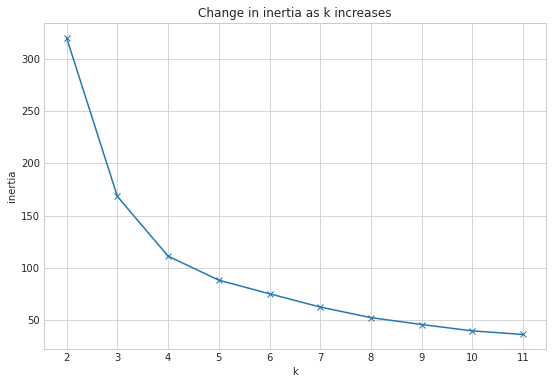

In [45]:
# plot inertia vs k for 'taxrate_age' cluster
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X3_train_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [46]:
# chose to examine 3 clusters, then make, fit and use the model to make centroids and predictions
kmeans = KMeans(n_clusters=3, random_state = 1234)

kmeans.fit(X3_train_scaled)

centroids3 = pd.DataFrame(kmeans.cluster_centers_, columns = X3_train_scaled.columns)

X3_train_scaled['cluster'] = kmeans.predict(X3_train_scaled)
train['taxrate_age_cluster'] = X3_train_scaled['cluster']

X3_train_scaled.head()

,taxrate,age,cluster
11097148,0.129330,0.430657,2
13904783,0.113528,0.437956,2
11558242,0.118154,0.000000,0
11884010,0.116623,0.751825,1
17258285,0.124419,0.583942,1


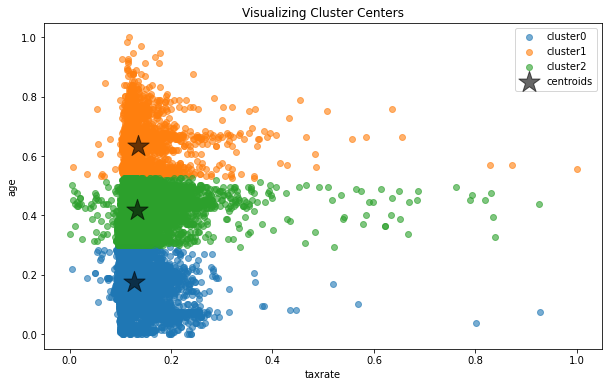

In [47]:
# visualize the clusters along with the centroids
plt.figure(figsize=(10, 6))

for cluster, subset in X3_train_scaled.groupby('cluster'):
    plt.scatter(subset.taxrate, subset.age, label='cluster' + str(cluster), alpha=.6)

centroids3.plot.scatter(x='taxrate', y='age', ax=plt.gca(), s=500, color='k', alpha=0.6, marker='*', label='centroids')

plt.title('Visualizing Cluster Centers')
plt.legend()
plt.show()

#### Takeaways
- vast majority of taxrate is low even as comapred to age

In [48]:
# use RFE to find best cluster for analysis
X = train[list(train.select_dtypes(exclude='category').columns)].drop(columns=['logerror'])
y = train['logerror']

lm = LinearRegression()
rfe = RFE(estimator=lm, n_features_to_select=1)
rfe.fit(X, y)

pd.Series(dict(zip(X.columns, rfe.ranking_))).sort_values()

taxrate                   1
bath_bed_ratio            2
bathrooms                 3
acres                     4
bbratio_value_cluster     5
bedrooms                  6
size_clusters             7
taxrate_age_cluster       8
age                       9
county_code              10
square_feet              11
taxes                    12
appraised_value          13
longitude                14
building_value           15
land_value               16
latitude                 17
dtype: int64

### Statistical Testing
- will focus on Cluster #2 - 'bbratio_value' cluster
- - 'bbratio_value' cluster was first cluster to appear in RFE list

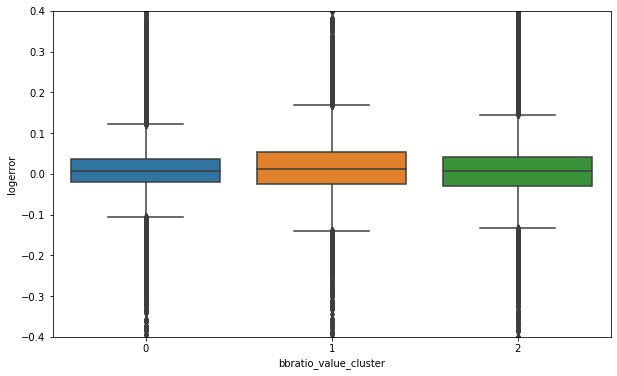

In [49]:
# boxplot of logerror to clusters
plt.figure(figsize=(10,6))
sns.boxplot(data=train, y='logerror', x='bbratio_value_cluster')
plt.ylim(-0.4, 0.4)
plt.show()

ANOVA Testing between all 3 clusters

In [50]:
# value_counts for clusters
train.bbratio_value_cluster.value_counts()

0    14176
2     8832
1     5923
Name: bbratio_value_cluster, dtype: int64

In [51]:
# create subsets for clusters
cluster0 = train[train.bbratio_value_cluster == 0].logerror
cluster1 = train[train.bbratio_value_cluster == 1].logerror
cluster2 = train[train.bbratio_value_cluster == 2].logerror

In [52]:
# run ANOVA test to determine if logerror is equal across all clusters
null_hypothesis = 'the logerror is the same across all 3 clusters.'
alt_hypothesis = 'the logerror is different in the clusters.'

alpha = 0.05

f, p = stats.f_oneway(cluster0, cluster1, cluster2)
f, p

(2.0898503550932395, 0.1237243227181968)

In [53]:
if p < alpha:
    print('Reject the null hypothesis.')
    print('There is evidence to support that', alt_hypothesis)
else:
    print('Fail to reject the null hypothesis.')
    print('There is evidence to support that', null_hypothesis)

Fail to reject the null hypothesis.
There is evidence to support that the logerror is the same across all 3 clusters.


T-test each cluster to population mean

In [54]:
# set hypotheses and alpha for t-tests
t_null = 'there is no difference in means between bnb_value_cluster cluster_0 and overall mean.'
t_alt = 'there is a difference between the cluster mean and the overall mean.'

t_alpha = 0.05

In [55]:
# testing cluster 0 againt the overall mean
t0, p0 = stats.ttest_1samp(train[train.bbratio_value_cluster == 0].logerror, train.logerror.mean())
t0, p0

if p0 < t_alpha:
    print('Can reject the null hypothesis that', t_null)
    print('There is evidence to support that', t_alt)
else:
    print('Fail to reject the null hypothesis.')
    print('There is evidence to support that', t_null)

Fail to reject the null hypothesis.
There is evidence to support that there is no difference in means between bnb_value_cluster cluster_0 and overall mean.


In [56]:
# testing cluster 1 againt the overall mean
t1, p1 = stats.ttest_1samp(train[train.bbratio_value_cluster == 1].logerror, train.logerror.mean())
t1, p1

if p1 < t_alpha:
    print('Can reject the null hypothesis that', t_null)
    print('There is evidence to support that', t_alt)
else:
    print('Fail to reject the null hypothesis.')
    print('There is evidence to support that', t_null)

Fail to reject the null hypothesis.
There is evidence to support that there is no difference in means between bnb_value_cluster cluster_0 and overall mean.


In [57]:
# testing cluster 2 againt the overall mean
t2, p2 = stats.ttest_1samp(train[train.bbratio_value_cluster == 2].logerror, train.logerror.mean())
t2, p2

if p2 < t_alpha:
    print('Can reject the null hypothesis that', t_null)
    print('There is evidence to support that', t_alt)
else:
    print('Fail to reject the null hypothesis.')
    print('There is evidence to support that', t_null)

Fail to reject the null hypothesis.
There is evidence to support that there is no difference in means between bnb_value_cluster cluster_0 and overall mean.


#### Takeaways: 
ANOVA Test
- results: f = 2.08985, p-value =  0.1237
- fail to reject the null hypothesis
- the mean logerror is the same across all 3 clusters
- indicates that the cluster is not a significant factor in logerror

T-tests
- failed to reject null hypothesis for each group
- the mean logerror for each group is the same as the overall mean
- confirms ANOVA results, clusters are not a significant factor in logerror

## Modeling and Evaluation
- will continue with 'bbratio_value' cluster

In [58]:
# scale the X subsets for modeling
X_train_scaled, X_validate_scaled, X_test_scaled = prepare.Min_Max_Scaler(X_train, X_validate, X_test)
X_train_scaled.head().T

parcelid,11097148,13904783,11558242,11884010,17258285
bathrooms,0.166667,0.166667,0.666667,0.333333,0.000000
bedrooms,0.500000,0.333333,0.500000,0.500000,0.000000
square_feet,0.123481,0.118559,0.266443,0.339024,0.020528
county_code,0.000000,0.297297,0.000000,0.000000,1.000000
latitude,0.605295,0.342499,0.468272,0.522140,0.625417
longitude,0.457867,0.755496,0.542632,0.689119,0.413005
building_value,0.013339,0.008247,0.127757,0.113790,0.001641
appraised_value,0.005302,0.021704,0.076157,0.048972,0.008233
land_value,0.001664,0.027935,0.052510,0.019255,0.011312
taxes,0.005951,0.021531,0.078627,0.049914,0.008908


In [59]:
# drop 'cluster' column in order to add centroids to modeling subsets
X2_train_scaled = X2_train_scaled.drop(columns='cluster')

In [60]:
# add clusters to train, validate and test dataframes
X_train_scaled['bbratio_value_cluster'] = kmeans.predict(X2_train_scaled)
X_validate_scaled['bbratio_value_cluster'] = kmeans.predict(X2_validate_scaled)
X_test_scaled['bbratio_value_cluster'] = kmeans.predict(X2_test_scaled)

In [61]:
# create dummies for bbratio_value_cluster and merge to subsets
dummy_df = pd.get_dummies(X_train_scaled.bbratio_value_cluster, prefix='bbratio_value_cluster')
X_train_scaled = pd.concat([X_train_scaled, dummy_df], axis=1)
dummy_df = pd.get_dummies(X_validate_scaled.bbratio_value_cluster, prefix='bbratio_value_cluster')
X_validate_scaled = pd.concat([X_validate_scaled, dummy_df], axis=1)
dummy_df = pd.get_dummies(X_test_scaled.bbratio_value_cluster, prefix='bbratio_value_cluster')
X_test_scaled = pd.concat([X_test_scaled, dummy_df], axis=1)

In [62]:
# drop 'bbratio_value_cluster' from subsets
X_train_scaled = X_train_scaled.drop(columns='bbratio_value_cluster')
X_validate_scaled = X_validate_scaled.drop(columns='bbratio_value_cluster')
X_test_scaled = X_test_scaled.drop(columns='bbratio_value_cluster')
X_train_scaled.head().T

parcelid,11097148,13904783,11558242,11884010,17258285
bathrooms,0.166667,0.166667,0.666667,0.333333,0.000000
bedrooms,0.500000,0.333333,0.500000,0.500000,0.000000
square_feet,0.123481,0.118559,0.266443,0.339024,0.020528
county_code,0.000000,0.297297,0.000000,0.000000,1.000000
latitude,0.605295,0.342499,0.468272,0.522140,0.625417
longitude,0.457867,0.755496,0.542632,0.689119,0.413005
building_value,0.013339,0.008247,0.127757,0.113790,0.001641
appraised_value,0.005302,0.021704,0.076157,0.048972,0.008233
land_value,0.001664,0.027935,0.052510,0.019255,0.011312
taxes,0.005951,0.021531,0.078627,0.049914,0.008908


In [63]:
# convert y_train into a dataframe and establish the baseline using the mean value of 'logerror'
y_train = pd.DataFrame({'actual': y_train})
y_train['baseline'] = y_train.actual.mean()

# convert y_validate into a dataframe and add the baseline
y_validate = pd.DataFrame({'actual': y_validate})
y_validate['baseline'] = y_train.actual.mean()

# evaluate the baseline on train and validate
print('Train RMSE Baseline model:', math.sqrt(mean_squared_error(y_train.actual, y_train.baseline)))
rmse_baseline = math.sqrt(mean_squared_error(y_validate.actual, y_validate.baseline))
print('Validate RMSE baseline:', rmse_baseline)

Train RMSE Baseline model: 0.16679976153851522
Validate RMSE baseline: 0.18069719636674905


In [64]:
# create a dataframe to collect and compare modeling results, add results for baseline
metric_df = pd.DataFrame(data=[{'model': 'mean_baseline', 'rmse_validate': rmse_baseline,
    'r^2_validate': explained_variance_score(y_validate.actual, y_validate.baseline)}])
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,0.180697,0.0


### Model1 - OLS (LinearRegression) 
- with only top property features returned by RFE

In [65]:
# make feature list using top property features - without the clusters
X1_cols = ['bathrooms', 'taxrate', 'acres']

X_train_1 = X_train_scaled[X1_cols]
X_validate_1 = X_validate_scaled[X1_cols]
X_test_1 = X_test_scaled[X1_cols]

In [66]:
# model1 using only top features list
#create the model
model1 = LinearRegression(normalize=True)
# fit the model
model1.fit(X_train_1, y_train.actual)
# use the model to make predictions
y_train['model1'] = model1.predict(X_train_1)
y_validate['model1'] = model1.predict(X_validate_1)
# evaluate the results
print('Train RMSE for model1:', math.sqrt(mean_squared_error(y_train.actual, y_train.model1)))
rmse_model1 = math.sqrt(mean_squared_error(y_validate.actual, y_validate.model1))
print('Validate RMSE model1:', rmse_model1)

Train RMSE for model1: 0.16666575826927343
Validate RMSE model1: 0.18063920292086158


In [67]:
# add results from model1
metric_df = metric_df.append({'model': 'model1', 'rmse_validate': rmse_model1,
    'r^2_validate': explained_variance_score(y_validate.actual, y_validate.model1)}, ignore_index=True)
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,0.180697,0.000000
1,model1,0.180639,0.000637


### Model2 - OLS (LinearRegression) 
- with top property features AND 'bbratio_value_cluster' clusters

In [68]:
# make feature list using top property features AND 'bbratio_value_clusters'
X2_cols = ['bathrooms', 'taxrate', 'acres', 'bbratio_value_cluster_0', 'bbratio_value_cluster_1', 'bbratio_value_cluster_2']

X_train_2 = X_train_scaled[X2_cols]
X_validate_2 = X_validate_scaled[X2_cols]
X_test_2 = X_test_scaled[X2_cols]

In [69]:
# model2 using top property features list AND 'bbratio_value_clusters'
#create the model
model2 = LinearRegression(normalize=True)
# fit the model
model2.fit(X_train_2, y_train.actual)
# use the model to make predictions
y_train['model2'] = model2.predict(X_train_2)
y_validate['model2'] = model2.predict(X_validate_2)
# evaluate the results
print('Train RMSE for model2:', math.sqrt(mean_squared_error(y_train.actual, y_train.model2)))
rmse_model2 = math.sqrt(mean_squared_error(y_validate.actual, y_validate.model2))
print('Validate RMSE model2:', rmse_model2)

Train RMSE for model2: 0.16666294011788213
Validate RMSE model2: 0.18058161804891845


In [70]:
# add results from model2
metric_df = metric_df.append({'model': 'model2', 'rmse_validate': rmse_model2,
    'r^2_validate': explained_variance_score(y_validate.actual, y_validate.model2)}, ignore_index=True)
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,0.180697,0.000000
1,model1,0.180639,0.000637
2,model2,0.180582,0.001280


### Model3 - LassoLars (alpha=1)
- with top property features AND 'bbratio_value_cluster' clusters

In [71]:
# model3 using top property features list AND 'bbratio_value_clusters'
#create the model
model3 = LassoLars(alpha=1)
# fit the model
model3.fit(X_train_2, y_train.actual)
# use the model to make predictions
y_train['model3'] = model3.predict(X_train_2)
y_validate['model3'] = model3.predict(X_validate_2)
# evaluate the results
print('Train RMSE for model3:', math.sqrt(mean_squared_error(y_train.actual, y_train.model3)))
rmse_model3 = math.sqrt(mean_squared_error(y_validate.actual, y_validate.model3))
print('Validate RMSE model3:', rmse_model3)

Train RMSE for model3: 0.16679976153851522
Validate RMSE model3: 0.18069719636674905


In [72]:
# add results from model3
metric_df = metric_df.append({'model': 'model3', 'rmse_validate': rmse_model3,
    'r^2_validate': explained_variance_score(y_validate.actual, y_validate.model3)}, ignore_index=True)
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,0.180697,0.000000e+00
1,model1,0.180639,6.374654e-04
2,model2,0.180582,1.280312e-03
3,model3,0.180697,2.220446e-16


### Model4 - Polynomial Regression (degree=2)
- with top property features AND 'bbratio_value_cluster' clusters

In [73]:
# make the polynomial features model
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_2
X_train_poly2 = pf.fit_transform(X_train_2)

# transform ONLY X_validate_2
X_validate_poly2 = pf.transform(X_validate_2)

In [74]:
# model4 using top property features list AND 'bbratio_value_clusters'
# create the model
model4 = LinearRegression(normalize=True)
# fit the model
model4.fit(X_train_poly2, y_train.actual)
# use the model to make predictions
y_train['model4'] = model4.predict(X_train_poly2)
y_validate['model4'] = model4.predict(X_validate_poly2)
# evaluate the reults on train and validate
print('Train RMSE for model4:', math.sqrt(mean_squared_error(y_train.actual, y_train.model4)))
rmse_model4 = math.sqrt(mean_squared_error(y_validate.actual, y_validate.model4))
print('Validate RMSE model4:', rmse_model4)

Train RMSE for model4: 0.16658748169751844
Validate RMSE model4: 0.18037483977783386


In [75]:
# add results from model4
metric_df = metric_df.append({'model': 'model4', 'rmse_validate': rmse_model4,
    'r^2_validate': explained_variance_score(y_validate.actual, y_validate.model4)}, ignore_index=True)
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,0.180697,0.000000e+00
1,model1,0.180639,6.374654e-04
2,model2,0.180582,1.280312e-03
3,model3,0.180697,2.220446e-16
4,model4,0.180375,3.565879e-03


#### Takeaways:
- LassoLars performed equal to the baseline, no improvement
- models 1, 2, and 4 outperformed the baseline
- all of the improvements less than 1%
- expected results due to results of ANOVA test

### Best Model - Polynomial Regression (degree=2)
- with top property features AND 'bbratio_value_cluster' clusters

In [76]:
# transform X_test_2
X_test_poly2 = pf.transform(X_test_2)
# create y_test dataframe
y_test = pd.DataFrame({'actual': y_test})
# use the model to make predictions
y_test['model4'] = model4.predict(X_test_poly2)
# evaluate the results
print('Test RMSE for model4:', math.sqrt(mean_squared_error(y_test.actual, y_test.model4)))
rmse_test = math.sqrt(mean_squared_error(y_test.actual, y_test.model4))
print('r^2_test:', explained_variance_score(y_test.actual, y_test.model4))

Test RMSE for model4: 0.18009927538251863
r^2_test: 0.0040515404079392026


In [77]:
# add results from best model run on test
metric_df = metric_df.append({'model': 'best model-test', 'rmse_validate': rmse_test,
    'r^2_validate': explained_variance_score(y_test.actual, y_test.model4)}, ignore_index=True)
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,0.180697,0.000000e+00
1,model1,0.180639,6.374654e-04
2,model2,0.180582,1.280312e-03
3,model3,0.180697,2.220446e-16
4,model4,0.180375,3.565879e-03
5,best model-test,0.180099,4.051540e-03


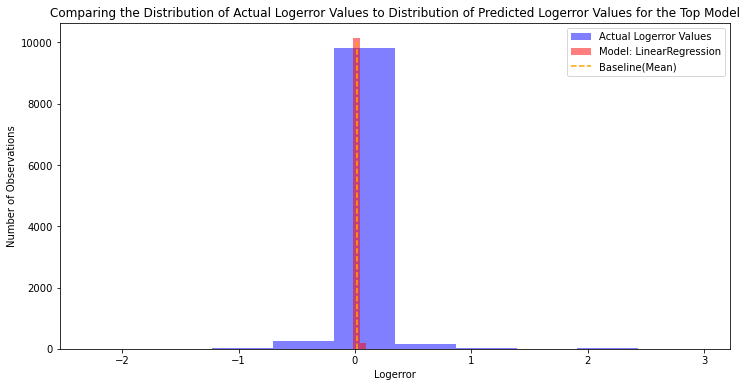

In [78]:
# plot to visualize actual vs predicted 
plt.figure(figsize=(12,6))
plt.hist(y_test.actual, color='blue', alpha=.5, label="Actual Logerror Values")
plt.vlines(y_train.actual.mean(), 0, 10000, ls='--', color='orange', label='Baseline(Mean)')
plt.hist(y_test.model4, color='red', alpha=.5, label='Model: LinearRegression')
plt.xlabel("Logerror")
plt.ylabel("Number of Observations")
plt.title("Comparing the Distribution of Actual Logerror Values to Distribution of Predicted Logerror Values for the Top Model")
plt.legend()
plt.show()

## Conclusions

- Polynomial Regression model with top property features and cluster did better than the baseline and the other models
-- Baseline RMSE: 0.180697, Test RMSE: 0.180099


- low R^2 value indicates that this model is not a good fit
-- R^2 value: 4.051540e-03


- outperformed the baseline...barely (less than 1%)

## With more time:
- deal with missing values differently to keep more of the features that were removed due to missing values
- make cluster groups that include more property features
- more clusters within each cluster group
- make cluster group that include location (county, longitude, latitude)
- adjust features and hyperparameters used in the models